In [41]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

plt.rcParams["figure.dpi"] = 140
plt.rcParams["font.family"] = 'sans-serif'

from colour import Color
import sys

from PIL import Image

sys.path.append('/home/jack/workspaces/jupyter-workspace/pepe/')
#sys.path.append('/eno/jdfeathe/pepe/')

from pepe.preprocess import circularMask, rectMask, checkImageType
from pepe.tracking import angularConvolution, convCircle
from pepe.topology import findPeaks1D, findPeaksMulti
from pepe.visualize import visCircles

[None, None, None, None]
[None, None, None, None]


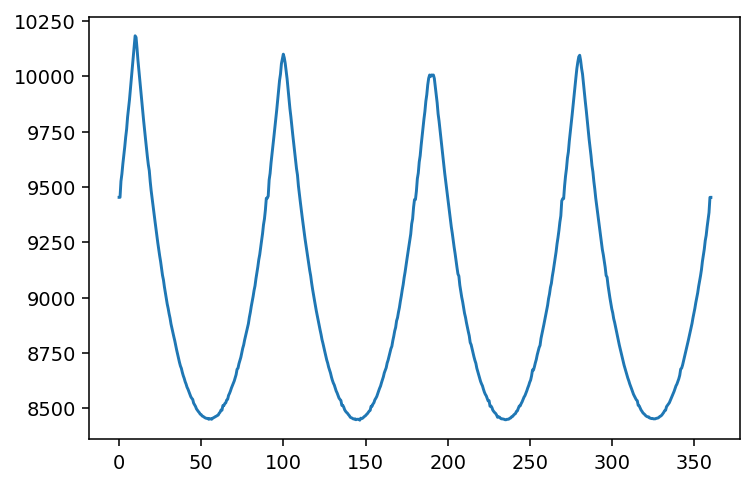

9.760765550239235


In [11]:
testCircle = rectMask((500, 500), np.array([200, 200]), np.array([100, 100]))[:,:,0]

img = Image.fromarray(testCircle)
rImg = img.rotate(10) # In degrees

angles, conv = angularConvolution(rImg, img, dTheta=.01)

plt.plot(angles, conv)
plt.show()

#print(findPeaksMulti(conv))
print(angles[findPeaksMulti(conv)[0][0]])

In [2]:
circleTrackingKwargs = {"intensitySoftmax": 2., "intensitySoftmin": 1.8, "peakDownsample": 2,
                        "minPeakPrevalence": .1, "offscreenParticles": False,
                        "radiusTolerance": None, "negativeHalo": True, "fitPeaks": False,
                        "allowOverlap": True}

guessRadius = 160

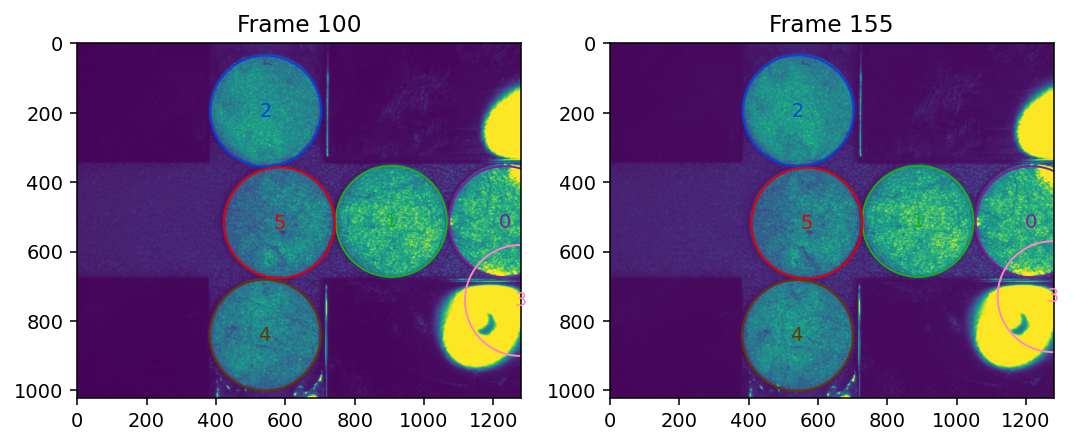

In [43]:
dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/2022-03-29_Medium/'
image1 = 'frame0100.bmp'
image2 = 'frame0155.bmp'

img1 = checkImageType(dataFolder + image1)[:,:,0]
img2 = checkImageType(dataFolder + image2)[:,:,0]

circles1, radii1 = convCircle(img1, guessRadius, **circleTrackingKwargs)
circles2, radii2 = convCircle(img2, guessRadius, **circleTrackingKwargs)

fig, ax = plt.subplots(1, 2, figsize=(9,4))

ax[0].imshow(img1)
ax[0].set_title('Frame 100')
visCircles(circles1, radii1, ax[0], annotations=np.arange(len(circles1)))

ax[1].imshow(img2)
ax[1].set_title('Frame 155')
visCircles(circles2, radii2, ax[1], annotations=np.arange(len(circles2)))

plt.savefig('../angular_conv_full.png')
plt.show()

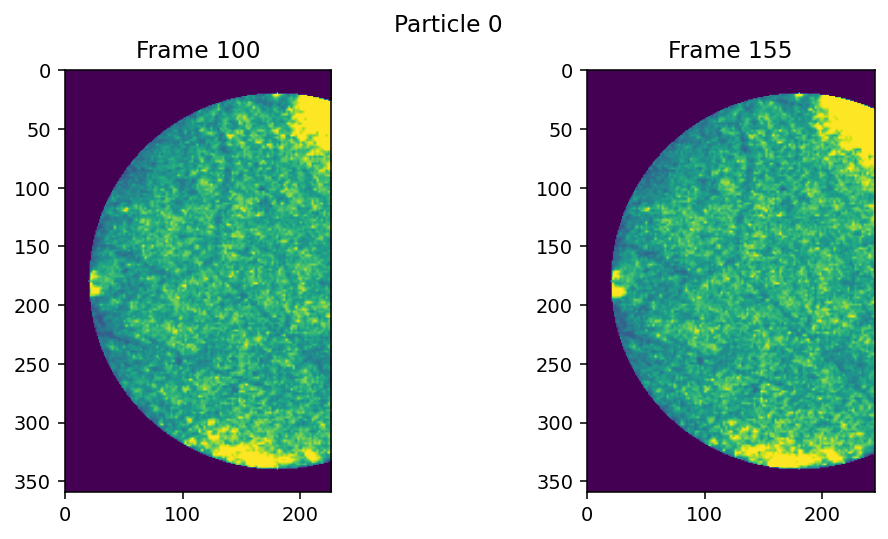

In [57]:
particleIndex = 0 # From image above
padding = guessRadius + 20

center1 = circles1[particleIndex]
croppedImage1 = img1 * circularMask(img1.shape, center1, guessRadius)[:,:,0]
croppedImage1 = croppedImage1[center1[0] - padding:center1[0] + padding, center1[1] - padding:center1[1] + padding]

center2 = circles2[particleIndex]
croppedImage2 = img2 * circularMask(img2.shape, center2, guessRadius)[:,:,0]
croppedImage2 = croppedImage2[center2[0] - padding:center2[0] + padding, center2[1] - padding:center2[1] + padding]

fig, ax = plt.subplots(1, 2, figsize=(9,4))

ax[0].imshow(croppedImage1)
ax[1].imshow(croppedImage2)

ax[0].set_title('Frame 100')
ax[1].set_title('Frame 155')

fig.suptitle(f'Particle {particleIndex}')

#fig.tight_layout()
#plt.savefig('../angular_conv_cropped_5.png')
plt.show()

In [58]:
angleArr, convArr = angularConvolution(croppedImage1, croppedImage2, angleBounds=(-.5, .5), dTheta=.005)

maxAngle = angleArr[findPeaksMulti(convArr)[0][0][0]]

plt.plot(angleArr, convArr)
plt.axvline(x=maxAngle, linestyle='--', c='gray', label=r'$\theta=' + f'{maxAngle:.5}$ rad')

plt.xlabel('Angle [rad]')
plt.ylabel('Convolution [au]')
plt.legend()

#plt.savefig('../angular_conv_single_4.png')
plt.show()

[None, None, 4, None]
[None, None, None, None]


ValueError: could not broadcast input array from shape (360,227) into shape (360,241)

[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]
[None, None, None, None]


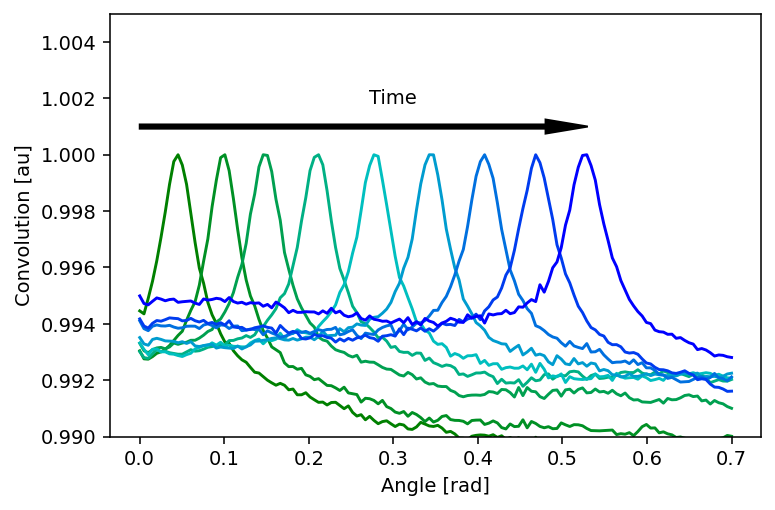

In [41]:
dataFolder = '/run/media/jack/Seagate Portable Drive/Research/SpaceJam/2022-03-29_Medium/'
refImage = 'frame0100.bmp'

particleIndex = 2 # From image above
padding = guessRadius + 20

images = [125, 150, 175, 200, 225, 250, 275, 300, 325]
colors = list(Color('green').range_to(Color("blue"),len(images)))

refImg = checkImageType(dataFolder + refImage)[:,:,0]
refCircles, refRadii = convCircle(refImg, guessRadius, **circleTrackingKwargs)

refCenter = refCircles[particleIndex]
refCropImg = refImg * circularMask(refImg.shape, refCenter, guessRadius)[:,:,0]
refCropImg = refCropImg[refCenter[0] - padding:refCenter[0] + padding, refCenter[1] - padding:refCenter[1] + padding]

for i in range(len(images)):
    
    img = checkImageType(dataFolder + f'frame0{images[i]}.bmp')[:,:,0]

    circles, radii = convCircle(img, guessRadius, **circleTrackingKwargs)

    center = circles[particleIndex]
    cropImg = img * circularMask(img.shape, center, guessRadius)[:,:,0]
    cropImg = cropImg[center[0] - padding:center[0] + padding, center[1] - padding:center[1] + padding]

    angleArr, convArr = angularConvolution(refCropImg, cropImg, angleBounds=(0, .7), dTheta=.005)

    convArr /= np.max(convArr)
    #maxAngle = angleArr[findPeaksMulti(convArr)[0][0][0]]

    plt.plot(angleArr, convArr, c=str(colors[i]))
    #plt.axvline(x=maxAngle, linestyle='--', c='gray', label=r'$\theta=' + f'{maxAngle:.5}$ rad')

plt.xlabel('Angle [rad]')
plt.ylabel('Convolution [au]')

plt.ylim([.99, 1.005])
plt.arrow(0, 1.001, .48, 0, head_width=0.0005, width=.00015, head_length=0.05, fc='k', ec='k')
plt.text(.3, 1.002, 'Time', ha='center', va='center')

plt.savefig('../angular_conv_test.png')
plt.show()

## What is the smallest angle we can rotate an image of dimension $N$ x $N$ by, $\theta_{min}(N)$

This test is done assuming images are completely random, but we can test (later on) that this holds for an actual image.

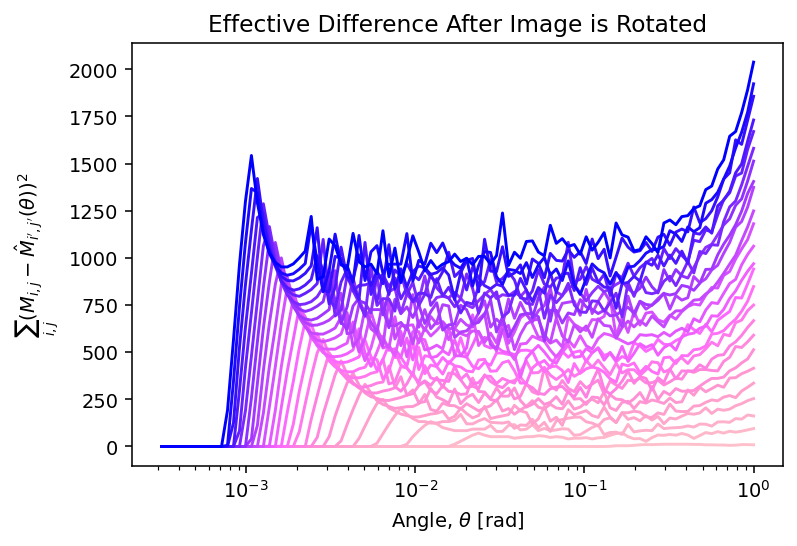

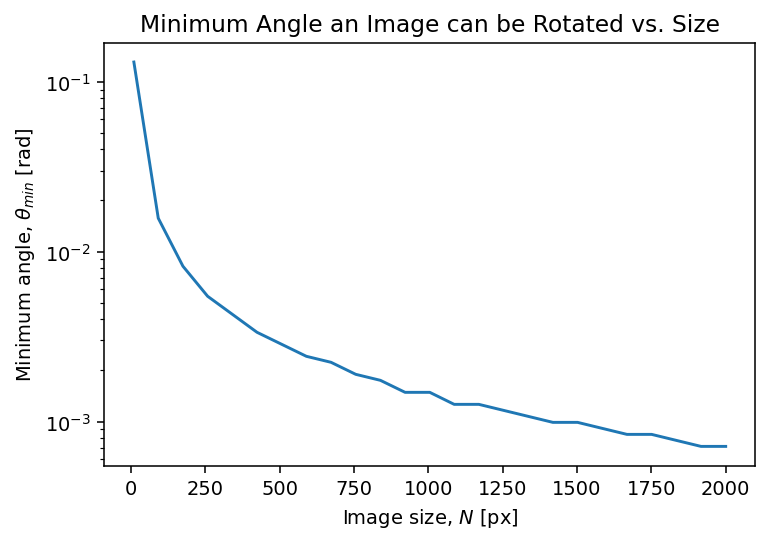

In [52]:
NArr = np.linspace(10, 2000, 25, dtype=np.int64)
minThetaArr = np.zeros(len(NArr))

colors = list(Color('pink').range_to(Color("blue"),len(NArr)))

testThetaArr = 10**np.linspace(0, -3.5, 100)

for i in range(len(NArr)):

    # To do this, we randomly generate some noise in a circle
    imgSize = np.repeat(NArr[i], 2)
    noiseImg = np.random.uniform(1, size=imgSize)
    fakeImg = circularMask(noiseImg.shape, np.array(noiseImg.shape)/2, int(imgSize[0]/3))[:,:,0] * noiseImg
    
    thetaDiffArr = np.zeros(len(testThetaArr))
    for j in range(len(thetaDiffArr)):
        thetaDiffArr[j] = np.sum((fakeImg - np.array(Image.fromarray(fakeImg).rotate(180/np.pi * testThetaArr[j])))**2)
    
    minThetaArr[i] = testThetaArr[np.where(thetaDiffArr == 0)[0][0]]
    plt.plot(testThetaArr, thetaDiffArr, c=str(colors[i]))
    
plt.xscale('log')
plt.xlabel(r'Angle, $\theta$ [rad]')
plt.ylabel(r"$\sum_{i,j}(M_{i,j} - \hat M_{i',j'}(\theta))^2$")
plt.title('Effective Difference After Image is Rotated')
plt.savefig('../images/angular_conv_min_angle_1.png')
plt.show()

plt.plot(NArr, minThetaArr)
plt.xlabel('Image size, $N$ [px]')
plt.ylabel(r'Minimum angle, $\theta_{min}$ [rad]')
plt.yscale('log')
plt.title('Minimum Angle an Image can be Rotated vs. Size')
plt.savefig('../images/angular_conv_min_angle_2.png')
plt.show()

(array([80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96,
        97, 98, 99]),)